# Kick Starter Analysis 
Nicklaus Porter

---

# Index: 
#Section 1: Welcome
#Section 2: Data Cleaning and Molding(Preparing for Tableau)
#Section 3: Viewing Totals and Averages
#Secton 4: Testing Kick Starter Data

---

# Section 1: Welcome!

My name is Nick. This is my first data project posted online. 
I first got this dataset at Kaggle.com. The data seemed fun to work with as it shows the outcomes of kickstart projects. After looking at it I wanted to analyze the data and determine if we could predict a kick starter projects outcome. In section 2 I sent the data to Tableau in order to create visualizations. In the other sections I was looking and testing the data.

---

# Section 2: Data Cleaning and Molding(Preparing for Tableau)

In [1]:
#Importing Data
import pandas as pd
import numpy as np 
from datetime import datetime
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
date_format = "%m/%d/%Y"
data = pd.read_csv("ks-projects-201801.csv")

In [2]:
#Cleaning initial columns 
data.columns = ['ID','Name', 'Category', 'Main_Category', 'Currency', 'Deadline','Goal', 'Launched', 'Pledged', 'State', 'Backers', 'Country','USD_Pledged', 'USD_Pledged_Real', 'USD_Goal_Real']
data.USD_Pledged = data.USD_Pledged.fillna(0)
data = data.dropna(how = 'any')
#Changed the value type to Category 
data.Main_Category = data.Main_Category.astype('category')
data.Category = data.Category.astype('category')



In [3]:
#Created a new column based on the amount missed by 
result = data.USD_Goal_Real - data.USD_Pledged_Real
data["Goal_Missed_AMT"] = result
#Turning the negative numbers created to 0. 
num = data._get_numeric_data()
num[num < 0] = 0
#Creating a new column that shows the length of each campaign
data['Launched'] = pd.to_datetime(data['Launched'])
data['Deadline'] = pd.to_datetime(data['Deadline'])
result1 = data['Deadline'] - data['Launched']
data['Campaign_Length_Days'] = result1
data['Campaign_Length_Days'] = [i.days for i in data['Campaign_Length_Days']]


In [4]:
#Creating a new column "Outcome" and making the results either Successful or failed
data["Outcome"] = data['State']
data["Outcome"] = data["Outcome"].replace('canceled', 'failed').replace('suspended', 'failed').replace('undefined','failed')
data = data[data.Outcome !='live']
#Dropping and Final Renaming of Columns
data = data.drop(["ID","Name","State","Goal","USD_Pledged","Pledged","Currency"], axis = 1)
data.columns = ['SubCategory','Category', 'Deadline','Launched_Date','Backers','Country','Pledged','Goal','Amount_Missed','Duration_Days','Outcome']



----

# Section 3: Viewing Totals and Averages


In [5]:
#data = data.sort_values('Main_Category')
#Finding_data_for_Campaigns_with_backers
Filter1 = data.Backers > 0 
Filter2 = data.Backers == 0
print "Number of projects with backers is",sum(Filter1)
print "Number of projects without backers is", sum(Filter2)


Number of projects with backers is 320799
Number of projects without backers is 55059


In [6]:
data.groupby('Outcome')[['Amount_Missed']].mean()

,Amount_Missed
Outcome,
failed,63677.050683
successful,0.040348


In [7]:
data.groupby('Outcome')[['Pledged']].mean()

,Pledged
Outcome,
failed,1558.249906
successful,22670.795231


In [8]:
data.groupby('Outcome')[['Duration_Days']].mean()

,Duration_Days
Outcome,
failed,34.706828
successful,31.156469


In [9]:
data.groupby('Outcome')[['Backers']].mean()

,Backers
Outcome,
failed,18.390671
successful,263.921362


---

# Section 4: Testing Kick Starter Data

In [10]:
#Importing Tools
import pandas
import matplotlib.pyplot as plt
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_classification
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
import datetime as dt

In [11]:
#Creating a new df and then Creating dummy Varibles
df=data #wanted to preserve the df I cleaned so I could work with it in Tableau or later
dummy_Category = pd.get_dummies(df['Category'],prefix='Category')
dummy_Country = pd.get_dummies(df['Country'],prefix='Country')
dummy_Outcome = pd.get_dummies(df['Outcome'],prefix='Outcome', drop_first = True)
df_new = pd.concat([df, dummy_Category, dummy_Country, dummy_Outcome], axis=1)
df_new = df_new.drop(["SubCategory",'Country','Category','Outcome','Amount_Missed', 'Backers', 'Pledged', 'Duration_Days'], axis = 1)

#Converting Deadline and Launched_Date to different values
df_new['Deadline'] = pd.to_datetime(df_new['Deadline'])
df_new['Deadline']=df_new['Deadline'].map(dt.datetime.toordinal)
df_new['Launched_Date'] = pd.to_datetime(df_new['Launched_Date'])
df_new['Launched_Date']=df_new['Launched_Date'].map(dt.datetime.toordinal)

#Changed Goal to integer
df_new.Goal = df_new.Goal.astype(int)

In [12]:
#Creating Train and Test
y = df_new.Outcome_successful
X = df_new.drop('Outcome_successful', 1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
print X_train.shape, y_train.shape
print X_test.shape, y_test.shape

(300686, 41) (300686,)
(75172, 41) (75172,)


LR: 0.643599 (0.002560)
KNN: 0.625526 (0.001654)
DT: 0.606264 (0.002027)
RF: 0.642530 (0.001857)


<function matplotlib.pyplot.show>

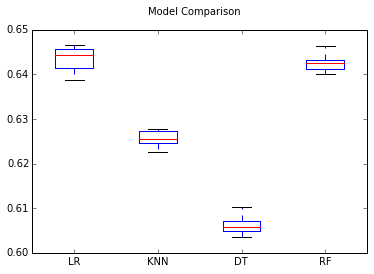

In [13]:
#Running Analysis with Logistic Regression, KNeighbors, Decision Tree, and Random Forest

seed = 0 #allows me to change value of non-random items inputed 
#Code that runs all the models I want at once
models = []
models.append(('LR', LogisticRegression()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('DT', DecisionTreeClassifier()))
models.append(('RF', RandomForestClassifier()))
#Evaluation each of the models that were run
results = []
names = []
scoring = 'accuracy'
for name, model in models:
    kfold = model_selection.KFold(n_splits=10, random_state=seed)
    cv_results = model_selection.cross_val_score(model, X, y, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)
#Plotting Comparisons on a Box plot
fig = plt.figure()
fig.suptitle('Model Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show